In [1]:
#coding:utf-8

import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
from multiprocessing import Process,Pool
import scipy.optimize as sciop
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import matplotlib.pyplot as plt
import scipy.integrate as sci_integrate
import seaborn as sns
import os  
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
#version 1:
'''parameters'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)


'''vac model(2 mass parameters)'''
def df_dtvac2(f,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a1=743.0/336+11.0*mu/4/M
    x=sciconsts.pi*M*f
    return 96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
def t_fvac2(f,m_1,m_2,figas):
    return sci_integrate.quad(lambda f:1.0/df_dtvac2(f,m_1,m_2),figas,f,limit=1500)[0]
'''reverse function :t(f) to f(t) to r(t)'''
def f_rvac(r,m):
    m_1=m[0]
    m_2=m[1]
    fi=m[2]
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a=np.sqrt(M)
    b=(-1.5+mu*0.5/M)
    return 1.0/sciconsts.pi*(a/np.power(r,1.5)+b/np.power(r,2.5)*np.power(M,1.5))-fi
def f_rvacstart(fi,m_1,m_2):
    M=m_1+m_2
    return np.power(np.power(M,0.5)/(sciconsts.pi*fi),2.0/3.0)

'''my T model(considering gas (c=G=1 unit))'''
def k_1cal(m_1,m_2):
    return 64.0*m_1*m_2*(m_1+m_2)/5.0
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)+np.power(a_0,4.0)/t_gas)
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1)*t_gas,0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt(m_1+m_2)*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)

In [2]:
#consts setting 
sivalue=1.0
#sivalue=t_scale/years
m_sun=1.9891e30*sciconsts.G/np.power(sciconsts.c,3.0)
years=365*24*3600.0
mpc=3.261*sciconsts.light_year
t_scale=years*sivalue

#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8/sciconsts.c
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)


# In[76]:

A=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=15000,epsabs=0.00005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
print Aval,Aerr,Aerr/Aval
sys.stdout.flush()

64376551.0817 4234.03572007 6.57698439716e-05


/Users/shyn/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


In [3]:

# In[78]:


# sciode
def df_dtode(f,t,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a1=743.0/336+11.0*mu/4/M
    x=sciconsts.pi*M*f
    result=96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)
    return result


# In[102]:

def dataconfirm(m):
    mcv=m[0]*m_sun
    smrv=m[1]
    sv=solvem(mcv,smrv)
    m1v=sv[0]
    m2v=sv[1]
    phic=m[2]
    n2=10000
    ts=np.linspace(0,t_scale,n2)
    yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
    ftv=sci_interpolate.interp1d(ts,yf.T[0])
    fr=ftv(ts)
    phiv1=np.zeros(n2)
    i=0
    while i<n2:
        phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
        i=i+1
    phiv=sci_interpolate.interp1d(ts,phiv1)
    
    rs=np.zeros(n2)
    rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])
    
    for i in range(1,n2,1):
        rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])
    
    rv=sci_interpolate.interp1d(ts,rs)
    
    t_scalev=ts[n2-1]
    t=np.linspace(0,t_scalev,num=Ng)
    hv=m1v*m2v/rv(t)*np.cos(phiv(t))
    xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
    hfvac1=fft.fft(hv)
    hfvac_abs=abs(hfvac1)
    hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
    hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
    hvacr=sci_interpolate.interp1d(xs,hfvac2)
    anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
    B=sci_integrate.quad(lambda x:4*np.power(hvacr(x),2.0)/S_n_lisa(x),figas,fr[n2-1],limit=1500,epsabs=0.005)
    Bval=np.sqrt(B[0])
    Berr=0.5/Bval*B[1]
    print Bval,Berr
    sys.stdout.flush()
    AB=sci_integrate.quad(lambda x:4*hvacr(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)+phic),figas,fr[n2-1],limit=2500,epsrel=0.005)
    ff=abs(AB[0]/Aval/Bval)
    err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)
    
    
    
    
    print ff,err
    sys.stdout.flush()
def vacconfirm(m):
    mcv=m[0]*m_sun
    smrv=m[1]
    sv=solvem(mcv,smrv)
    m1v=sv[0]
    m2v=sv[1]
    t_scale=m[2]
    n2=10000
    ts=np.linspace(0,t_scale,n2)
    yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
    ftv=sci_interpolate.interp1d(ts,yf.T[0])
    fr=ftv(ts)
    phiv1=np.zeros(n2)
    i=0
    while i<n2:
        phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
        i=i+1
    phiv=sci_interpolate.interp1d(ts,phiv1)
    
    rs=np.zeros(n2)
    rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])
    
    for i in range(1,n2,1):
        rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])
    
    rv=sci_interpolate.interp1d(ts,rs)
    

In [6]:
dataconfirm([3.69400000e+01,0.24,3.10985939e+00])

716235277.512 198240.520681
0.984880356842 0.00038811818655


In [67]:
(m_1g+m_2g)/a_0

0.00010035967527197216

In [71]:
(m_1g*m_2g/(m_1g+m_2g)/(m_1g+m_2g)-1.5)*(m_1g+m_2g)/a_0

-0.00012623094104277467

In [72]:
def df_dtodegas(f,t,m_1,m_2):
    m_c=chirp_mass(m_1,m_2)
    M=m_1+m_2
    mu=m_1*m_2/(m_1+m_2)
    a1=743.0/336+11.0*mu/4/M
    x=sciconsts.pi*M*f
    result=96.0/5*np.power(sciconsts.pi,8.0/3.0)*np.power(m_c,5.0/3.0)*np.power(f,11.0/3.0)*(1-a1*np.power(x,2.0/3.0)+4*sciconsts.pi*x)+1.5*f/t_gas
    return result

In [128]:
n2=1000000
ts=np.linspace(0,t_scale,n2)
yf=sci_integrate.odeint(df_dtodegas,figas,ts,args=(m_1g,m_2g)).T

In [129]:
yf2=freq_tgas(ts,m_1g,m_2g,t_gas,t_0g)

In [130]:
abs((yf-yf2)/yf).max()

1.0234670136675555e-08

In [131]:
abs(yf-yf2).max()

3.2627364785625668e-11

In [102]:
help(sci_integrate.odeint)

Help on function odeint in module scipy.integrate.odepack:

odeint(func, y0, t, args=(), Dfun=None, col_deriv=0, full_output=0, ml=None, mu=None, rtol=None, atol=None, tcrit=None, h0=0.0, hmax=0.0, hmin=0.0, ixpr=0, mxstep=0, mxhnil=0, mxordn=12, mxords=5, printmessg=0)
    Integrate a system of ordinary differential equations.
    
    Solve a system of ordinary differential equations using lsoda from the
    FORTRAN library odepack.
    
    Solves the initial value problem for stiff or non-stiff systems
    of first order ode-s::
    
        dy/dt = func(y, t0, ...)
    
    where y can be a vector.
    
    *Note*: The first two arguments of ``func(y, t0, ...)`` are in the
    opposite order of the arguments in the system definition function used
    by the `scipy.integrate.ode` class.
    
    Parameters
    ----------
    func : callable(y, t0, ...)
        Computes the derivative of y at t0.
    y0 : array
        Initial condition on y (can be a vector).
    t : array
        

In [7]:
m=[3.69400000e+01,2.40000000e-01,3.10985939e+00]
mcv=m[0]*m_sun
smrv=m[1]
sv=solvem(mcv,smrv)
m1v=sv[0]
m2v=sv[1]
phic=m[2]
n2=10000
ts=np.linspace(0,t_scale,n2)
yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
ftv=sci_interpolate.interp1d(ts,yf.T[0])
fr=ftv(ts)
phiv1=np.zeros(n2)
i=0
while i<n2:
    phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
    i=i+1
phiv=sci_interpolate.interp1d(ts,phiv1)

rs=np.zeros(n2)
rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])

for i in range(1,n2,1):
    rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])

rv=sci_interpolate.interp1d(ts,rs)

t_scalev=ts[n2-1]
t=np.linspace(0,t_scalev,num=Ng)
hv=m1v*m2v/rv(t)*np.cos(phiv(t))
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfvac1=fft.fft(hv)
hfvac_abs=abs(hfvac1)
hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
hvacr=sci_interpolate.interp1d(xs,hfvac2)
anglevac=sci_interpolate.interp1d(xs,hfvac_angle)
B=sci_integrate.quad(lambda x:4*np.power(hvacr(x),2.0)/S_n_lisa(x),figas,fr[n2-1],limit=1500,epsabs=0.005)
Bval=np.sqrt(B[0])
Berr=0.5/Bval*B[1]
print Bval,Berr
sys.stdout.flush()
AB=sci_integrate.quad(lambda x:4*hvacr(x)*hs(x)/S_n_lisa(x)*np.cos(anglegas(x)-anglevac(x)+phic),figas,fr[n2-1],limit=2500,epsrel=0.005)
ff=abs(AB[0]/Aval/Bval)
err=abs(1/Aval/Bval*AB[1])+abs(AB[0]/Aval/Aval/Bval*Aerr)+abs(AB[0]/Aval/Bval/Bval*Berr)




print ff,err

716235277.512 198240.520681
0.984880356842 0.00038811818655


In [15]:
tdomin=np.linspace(0,t_scale,10000)
fgas=freq_tgas(tdomin,m_1g,m_2g,t_gas,t_0g)
fvac=ftv(tdomin)
err=abs(fvac-fgas)

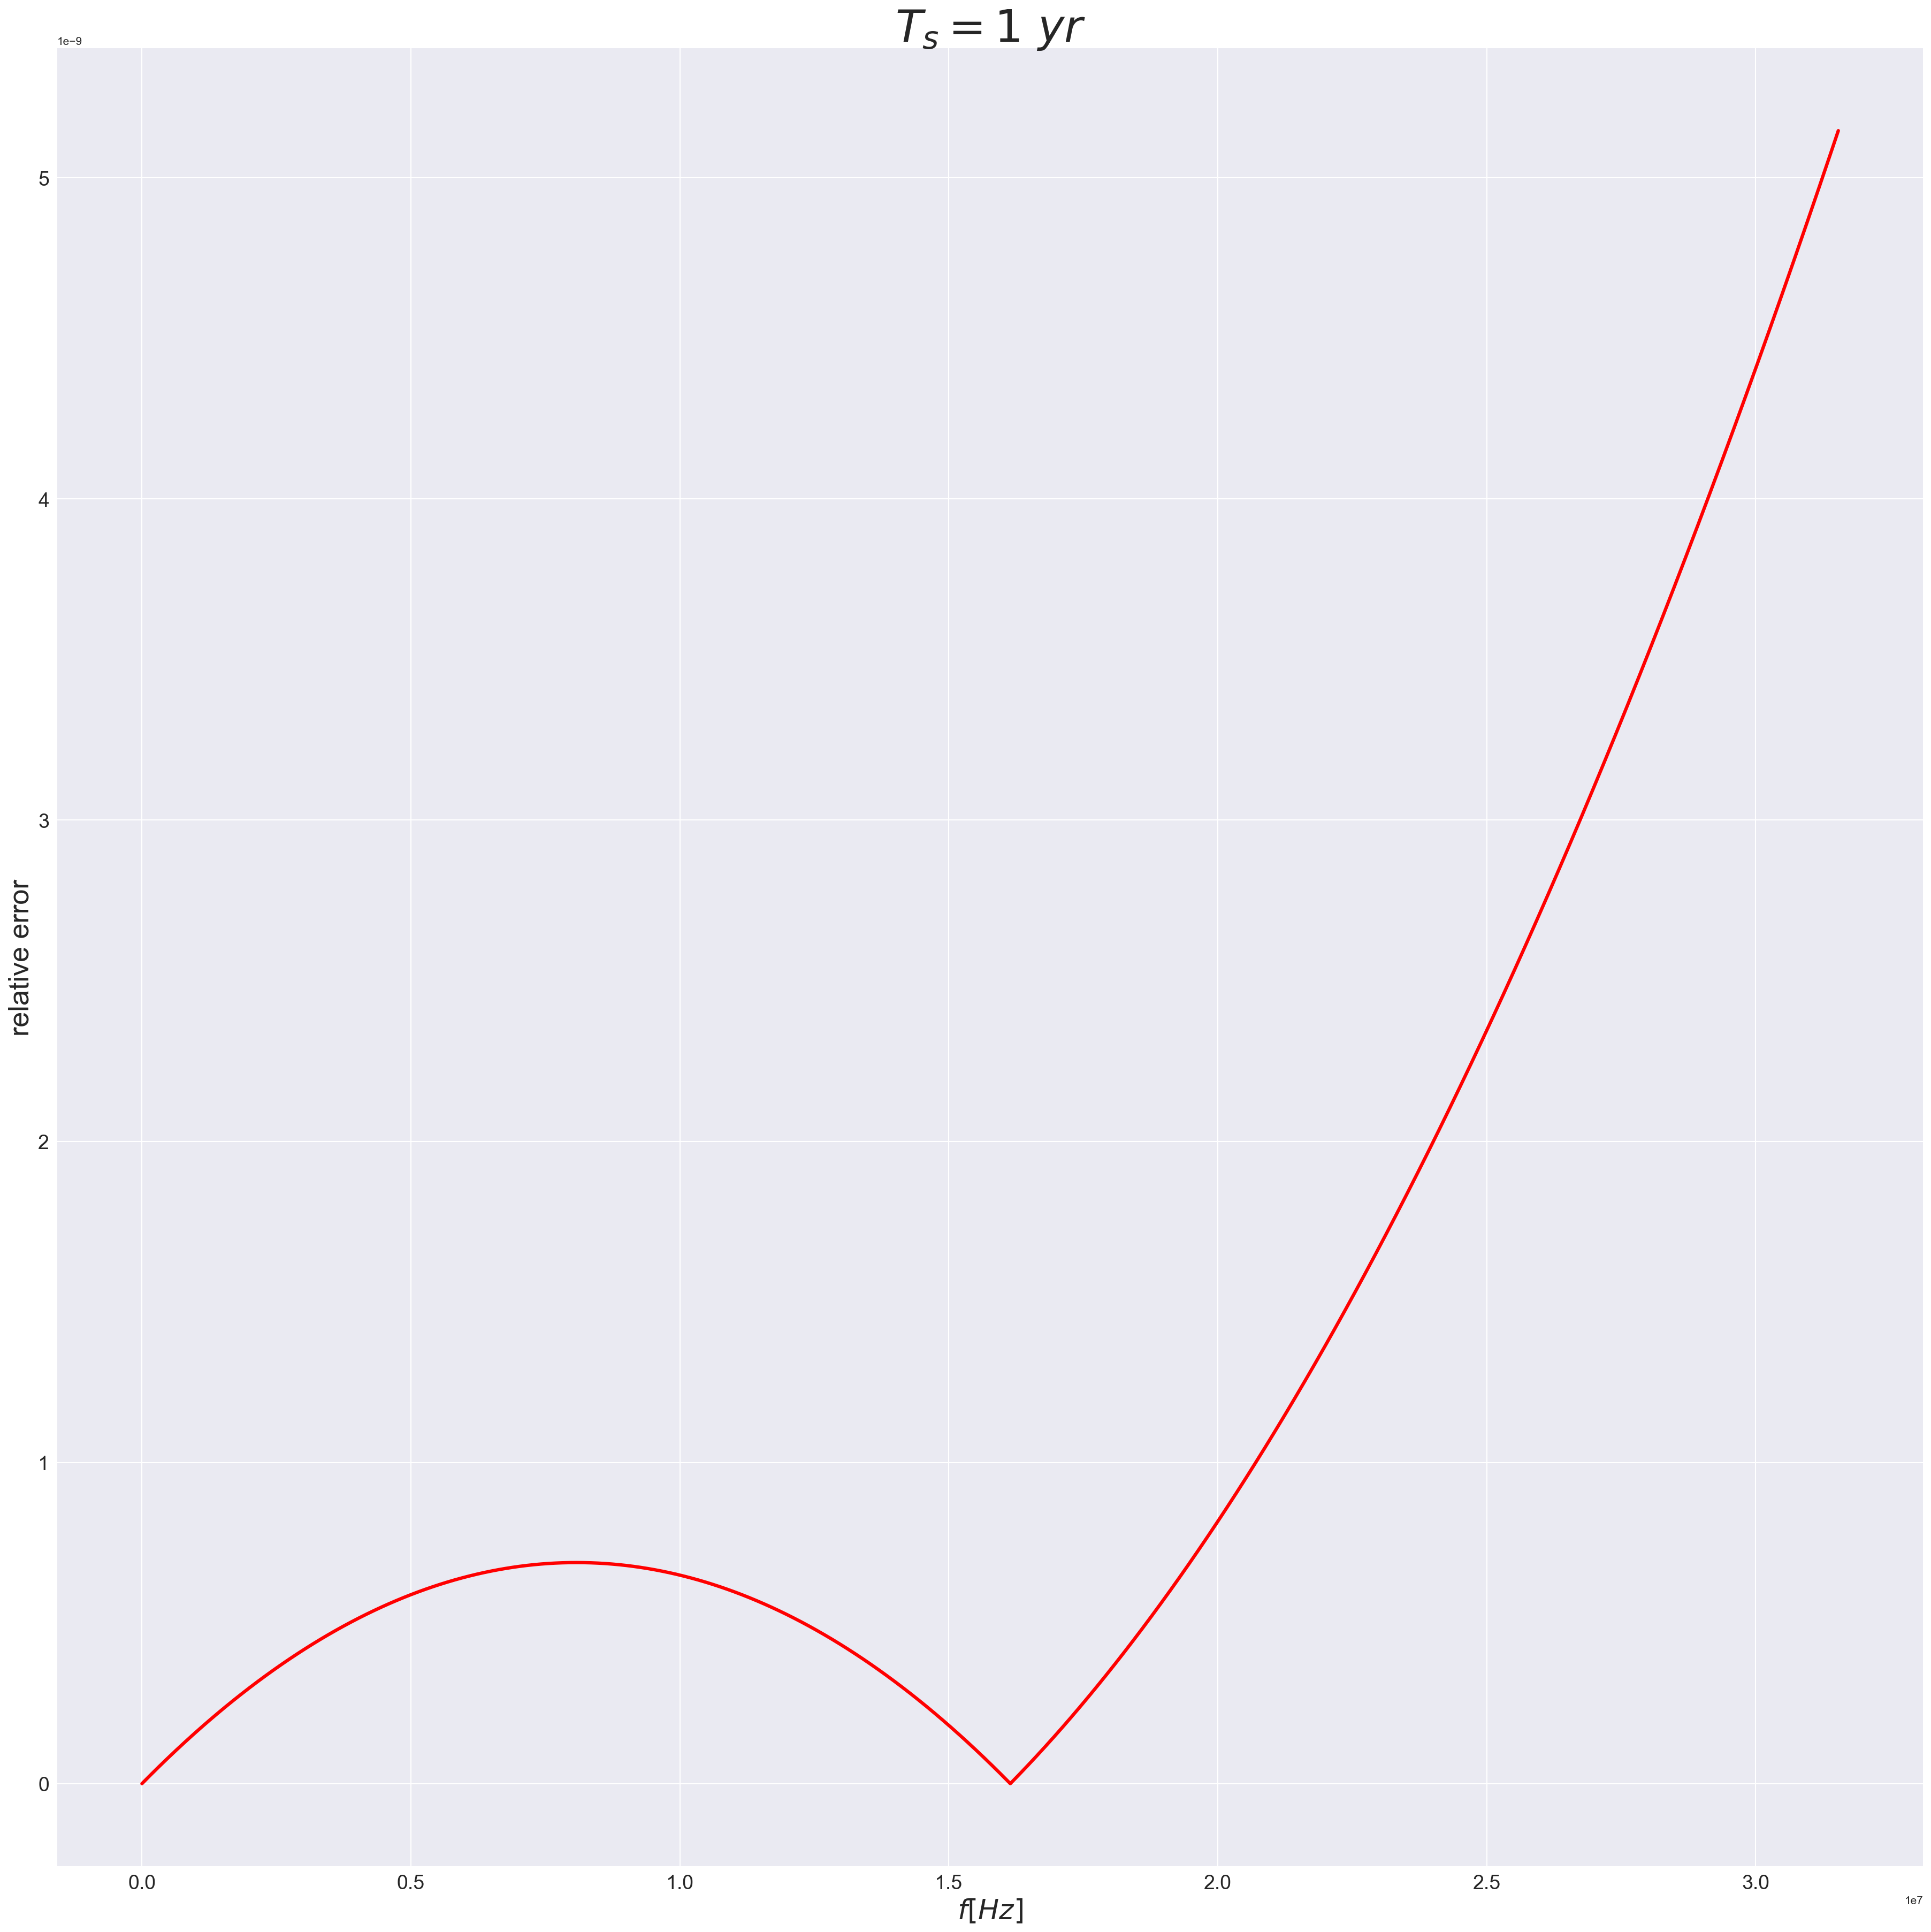

In [16]:
tdomin=np.linspace(0,t_scale,10000)
fgas=freq_tgas(tdomin,m_1g,m_2g,t_gas,t_0g)
fvac=ftv(tdomin)
err=abs(fvac-fgas)
plt.clf()
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.title(r'$T_s=1\ yr$',fontsize=40)
plt.ylabel('relative error',fontsize=25)
plt.xlabel(r'$f[Hz]$',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(tdomin,err,color='red',linewidth=3.0)
plt.show()

In [4]:
mpc=3.261*sciconsts.light_year
1e6*mpc

3.085144207108599e+22

In [3]:
solvem(36.9,0.25)

array([ 42.3869693,  42.3869693])

In [35]:
mcv=chirp_mass(43*m_sun,43*m_sun)
smrv=0.25
sv=solvem(mcv,smrv)
m1v=sv[0]
m2v=sv[1]
t_scale=365*24*3600.0
n2=1000

In [36]:
ts=np.linspace(0,t_scale,n2)
yf=sci_integrate.odeint(df_dtode,figas,ts,args=(m1v,m2v))
ftv=sci_interpolate.interp1d(ts,yf.T[0])
fr=ftv(ts)
phiv1=np.zeros(n2)
i=0
while i<n2:
    phiv1[i]=sci_integrate.quad(lambda x:2*sciconsts.pi*ftv(x),0,ts[i])[0]
    i=i+1
phiv=sci_interpolate.interp1d(ts,phiv1)

rs=np.zeros(n2)
rs[0]=sciop.fsolve(f_rvac,f_rvacstart(figas,m1v,m2v),args=[m1v,m2v,figas])

for i in range(1,n2,1):
    rs[i]=sciop.fsolve(f_rvac,rs[i-1],args=[m1v,m2v,fr[i]])

rv=sci_interpolate.interp1d(ts,rs)

In [42]:
rv(0)*sciconsts.c/au

0.0032396617439184325

In [43]:
p1=np.load('/Users/shyn/Desktop/Output/p1t1.npy')
p31=np.load('/Users/shyn/Desktop/Output/p31t1.npy')
yr=365*24*3600.0
au=sciconsts.astronomical_unit

array([[  3.23966075e-03,   9.98068683e-04,   6.53731205e+00,
          2.53932050e+01],
       [  3.23966052e-03,   9.98087745e-04,   6.79493654e+00,
          5.11448684e+01],
       [  3.23966027e-03,   9.98121906e-04,   7.08026190e+00,
          7.96748844e+01],
       ..., 
       [  2.96837673e-03,   1.04378765e-03,   3.37278742e+05,
          3.15359924e+07],
       [  2.96837666e-03,   1.04379204e-03,   3.37278829e+05,
          3.15360000e+07],
       [  2.96837666e-03,   1.04379204e-03,   3.37278829e+05,
          3.15360000e+07]])

In [44]:
rp1=sci_interpolate.interp1d(p1.T[3],p1.T[0]*au)
rp31=sci_interpolate.interp1d(p31.T[3],p31.T[0]*au)

In [56]:
phip1=sci_interpolate.interp1d(p1.T[3],p1.T[2])
phip31=sci_interpolate.interp1d(p31.T[3],p31.T[2])

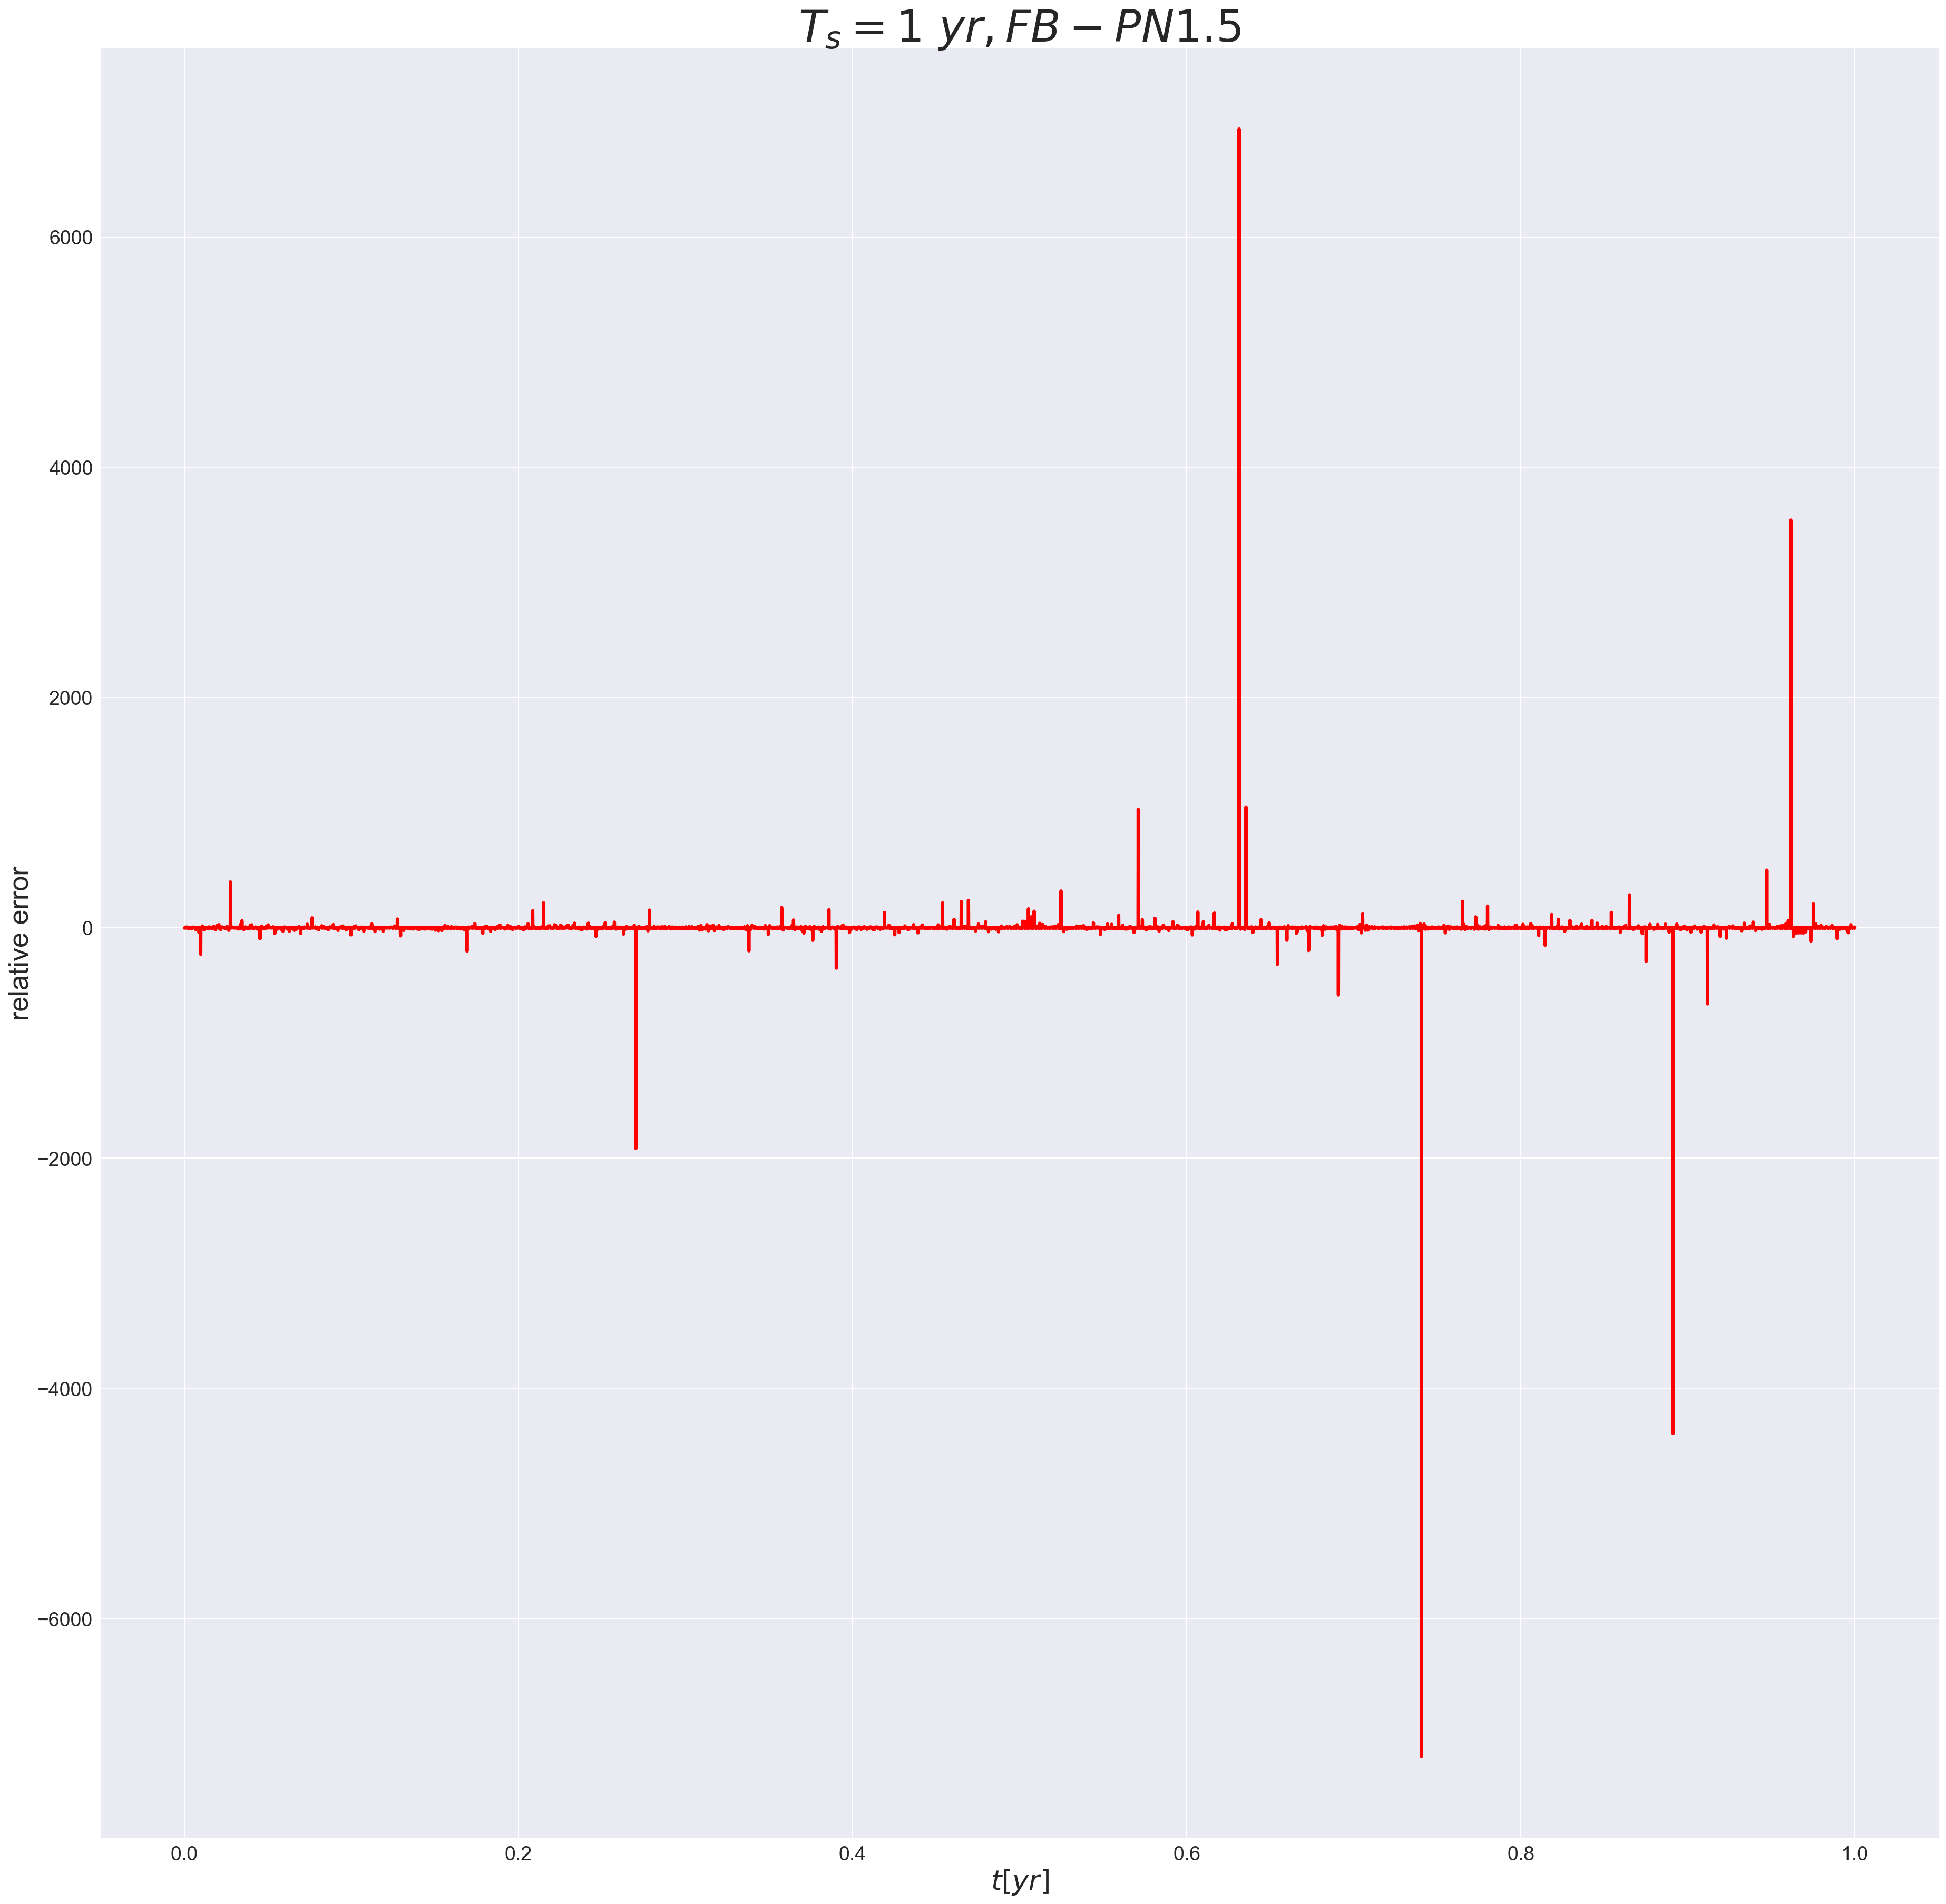

In [59]:
t_scale=1.0*yr
tdomin=np.linspace(100,t_scale-100,10000)
errp1=abs(np.cos(phip1(tdomin))-np.cos(phiv(tdomin)))/np.cos(phiv(tdomin))
errp31=abs(np.cos(phip31(tdomin))-np.cos(phiv(tdomin)))/np.cos(phiv(tdomin))
plt.clf()
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.title(r'$T_s=1\ yr,FB-PN1.5$',fontsize=40)
plt.ylabel('relative error',fontsize=25)
plt.xlabel(r'$t[yr]$',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(tdomin/yr,errp1,color='red',linewidth=3.0)
#plt.plot(tdomin,errp31,color='blue',linewidth=3.0)
plt.show()

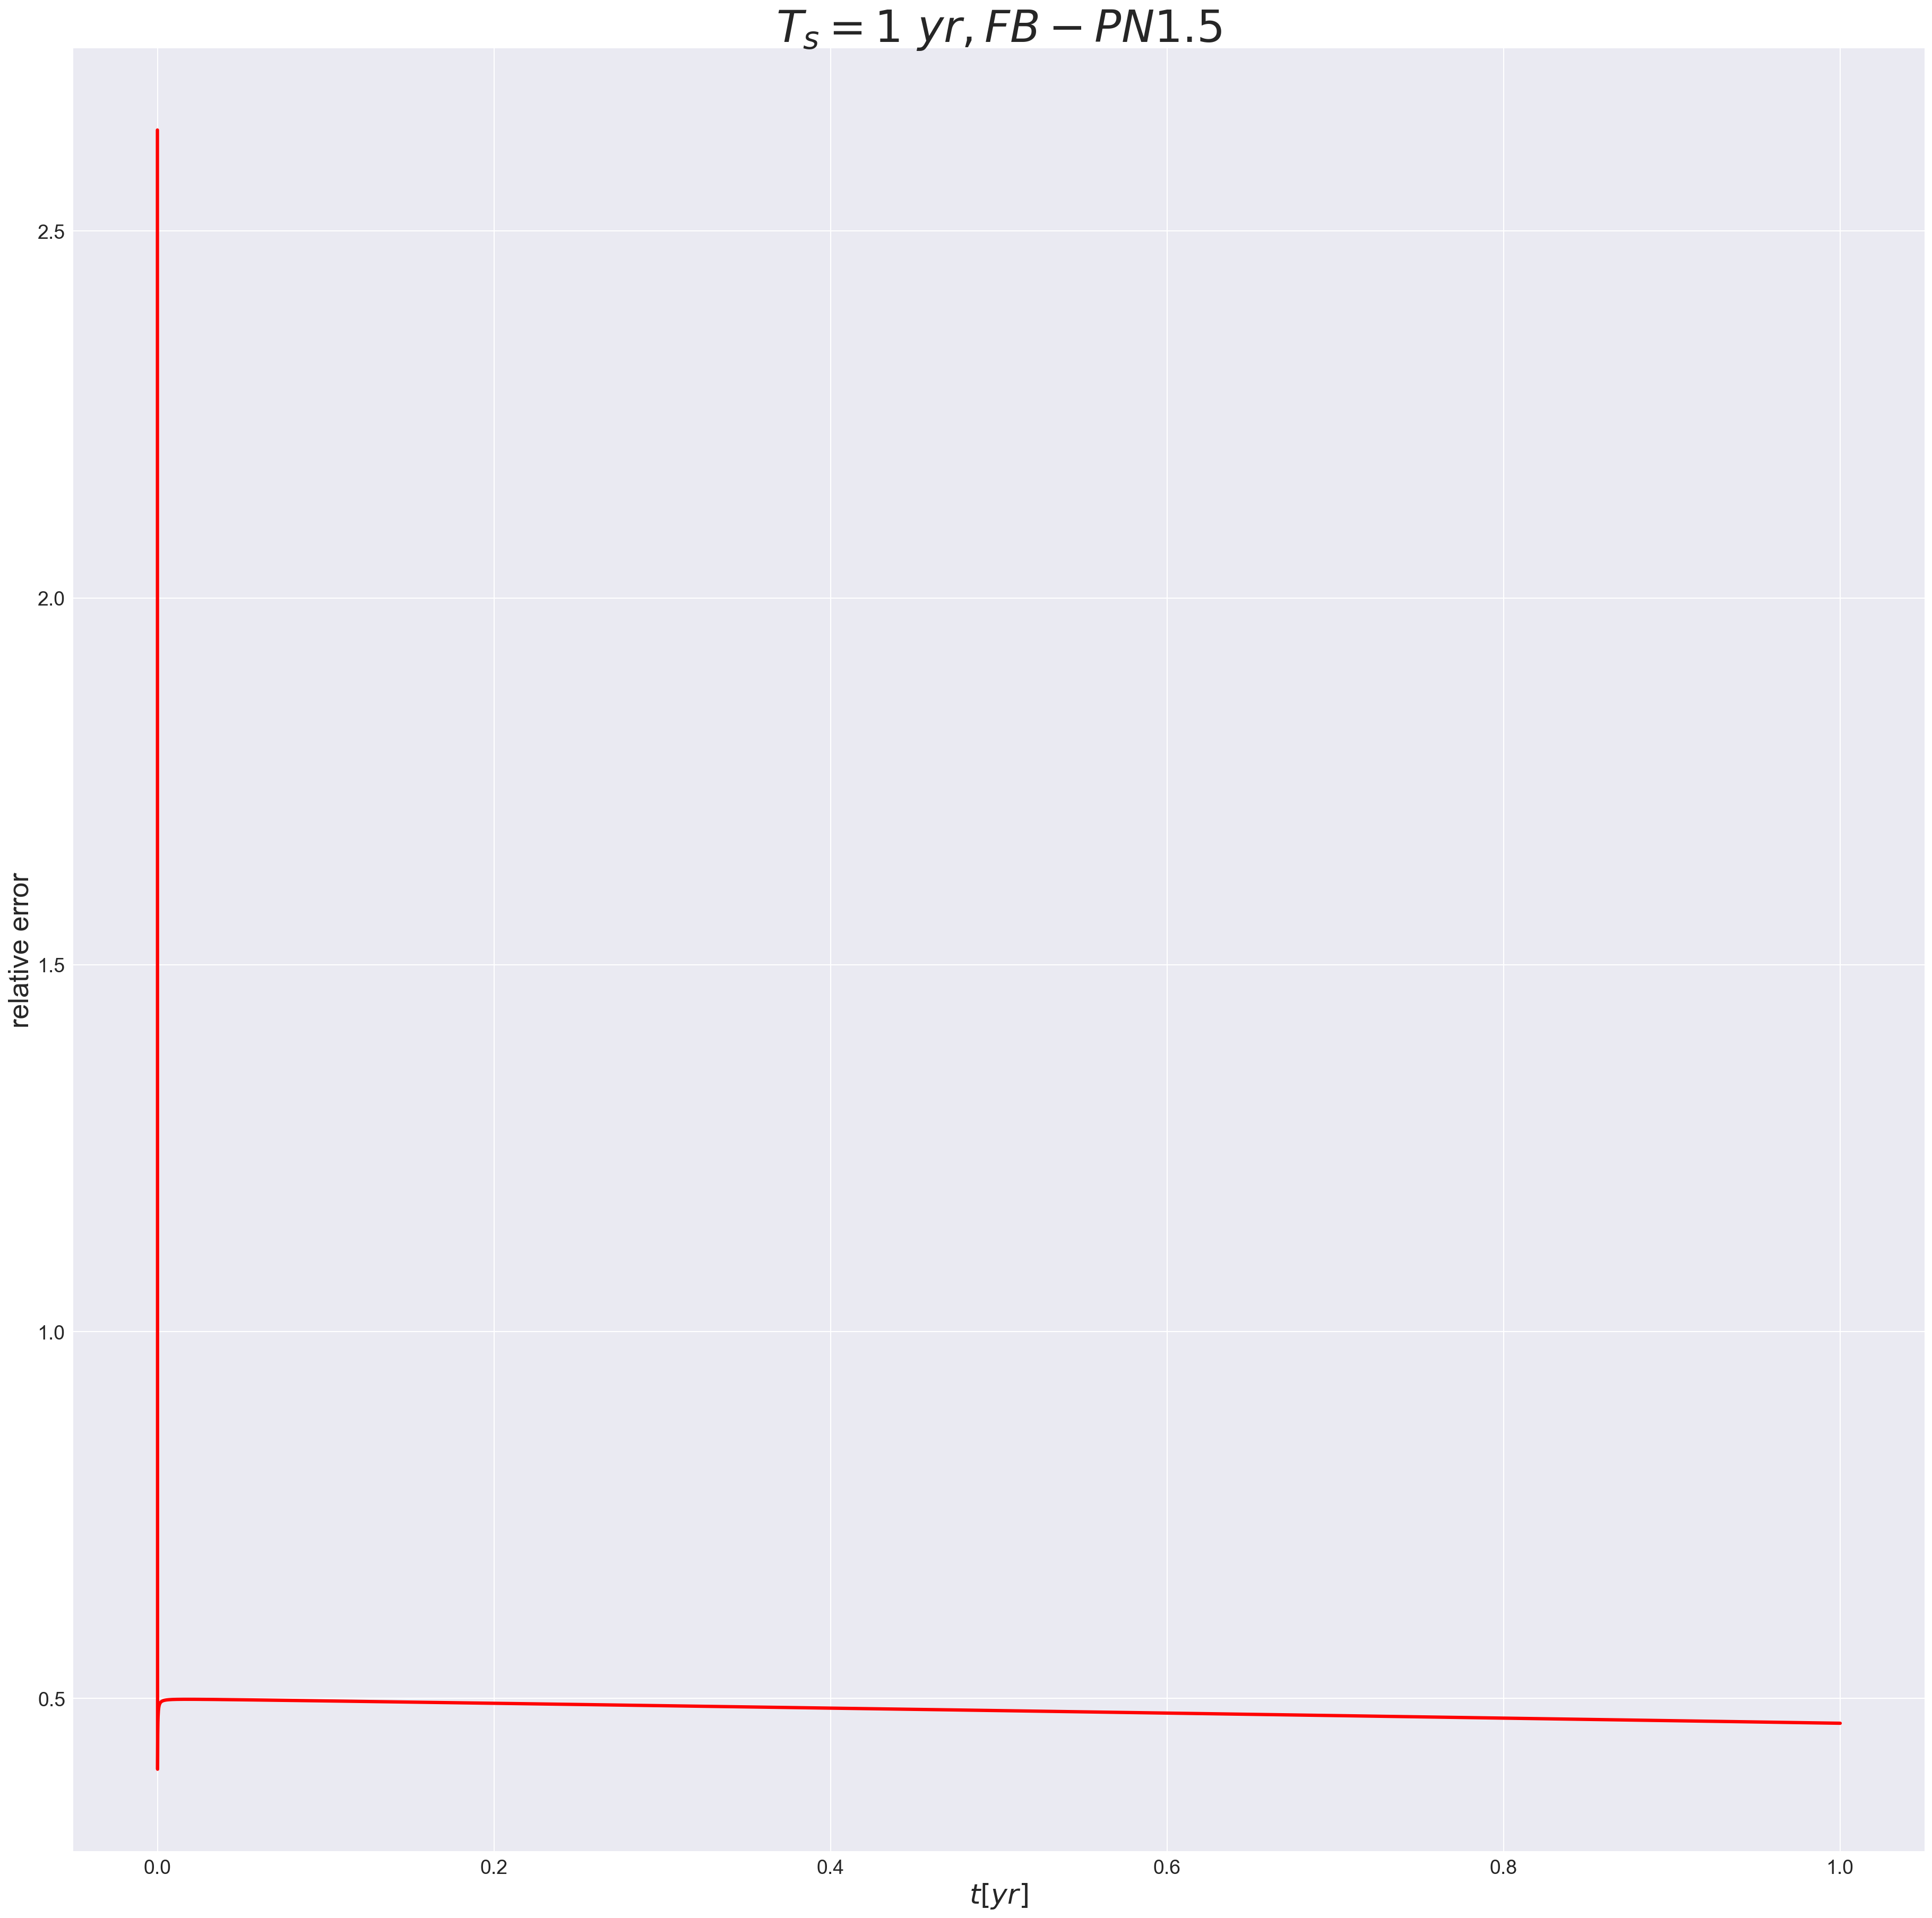

In [60]:
t_scale=1.0*yr
tdomin=np.linspace(100,t_scale-100,10000)
errp1=abs(phip1(tdomin)-phiv(tdomin))/phiv(tdomin)
#errp1=abs(np.cos(phip31(tdomin))-np.cos(phiv(tdomin)))/np.cos(phiv(tdomin))
plt.clf()
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.title(r'$T_s=1\ yr,FB-PN1.5$',fontsize=40)
plt.ylabel('relative error',fontsize=25)
plt.xlabel(r'$t[yr]$',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(tdomin/yr,errp1,color='red',linewidth=3.0)
#plt.plot(tdomin,errp31,color='blue',linewidth=3.0)
plt.show()

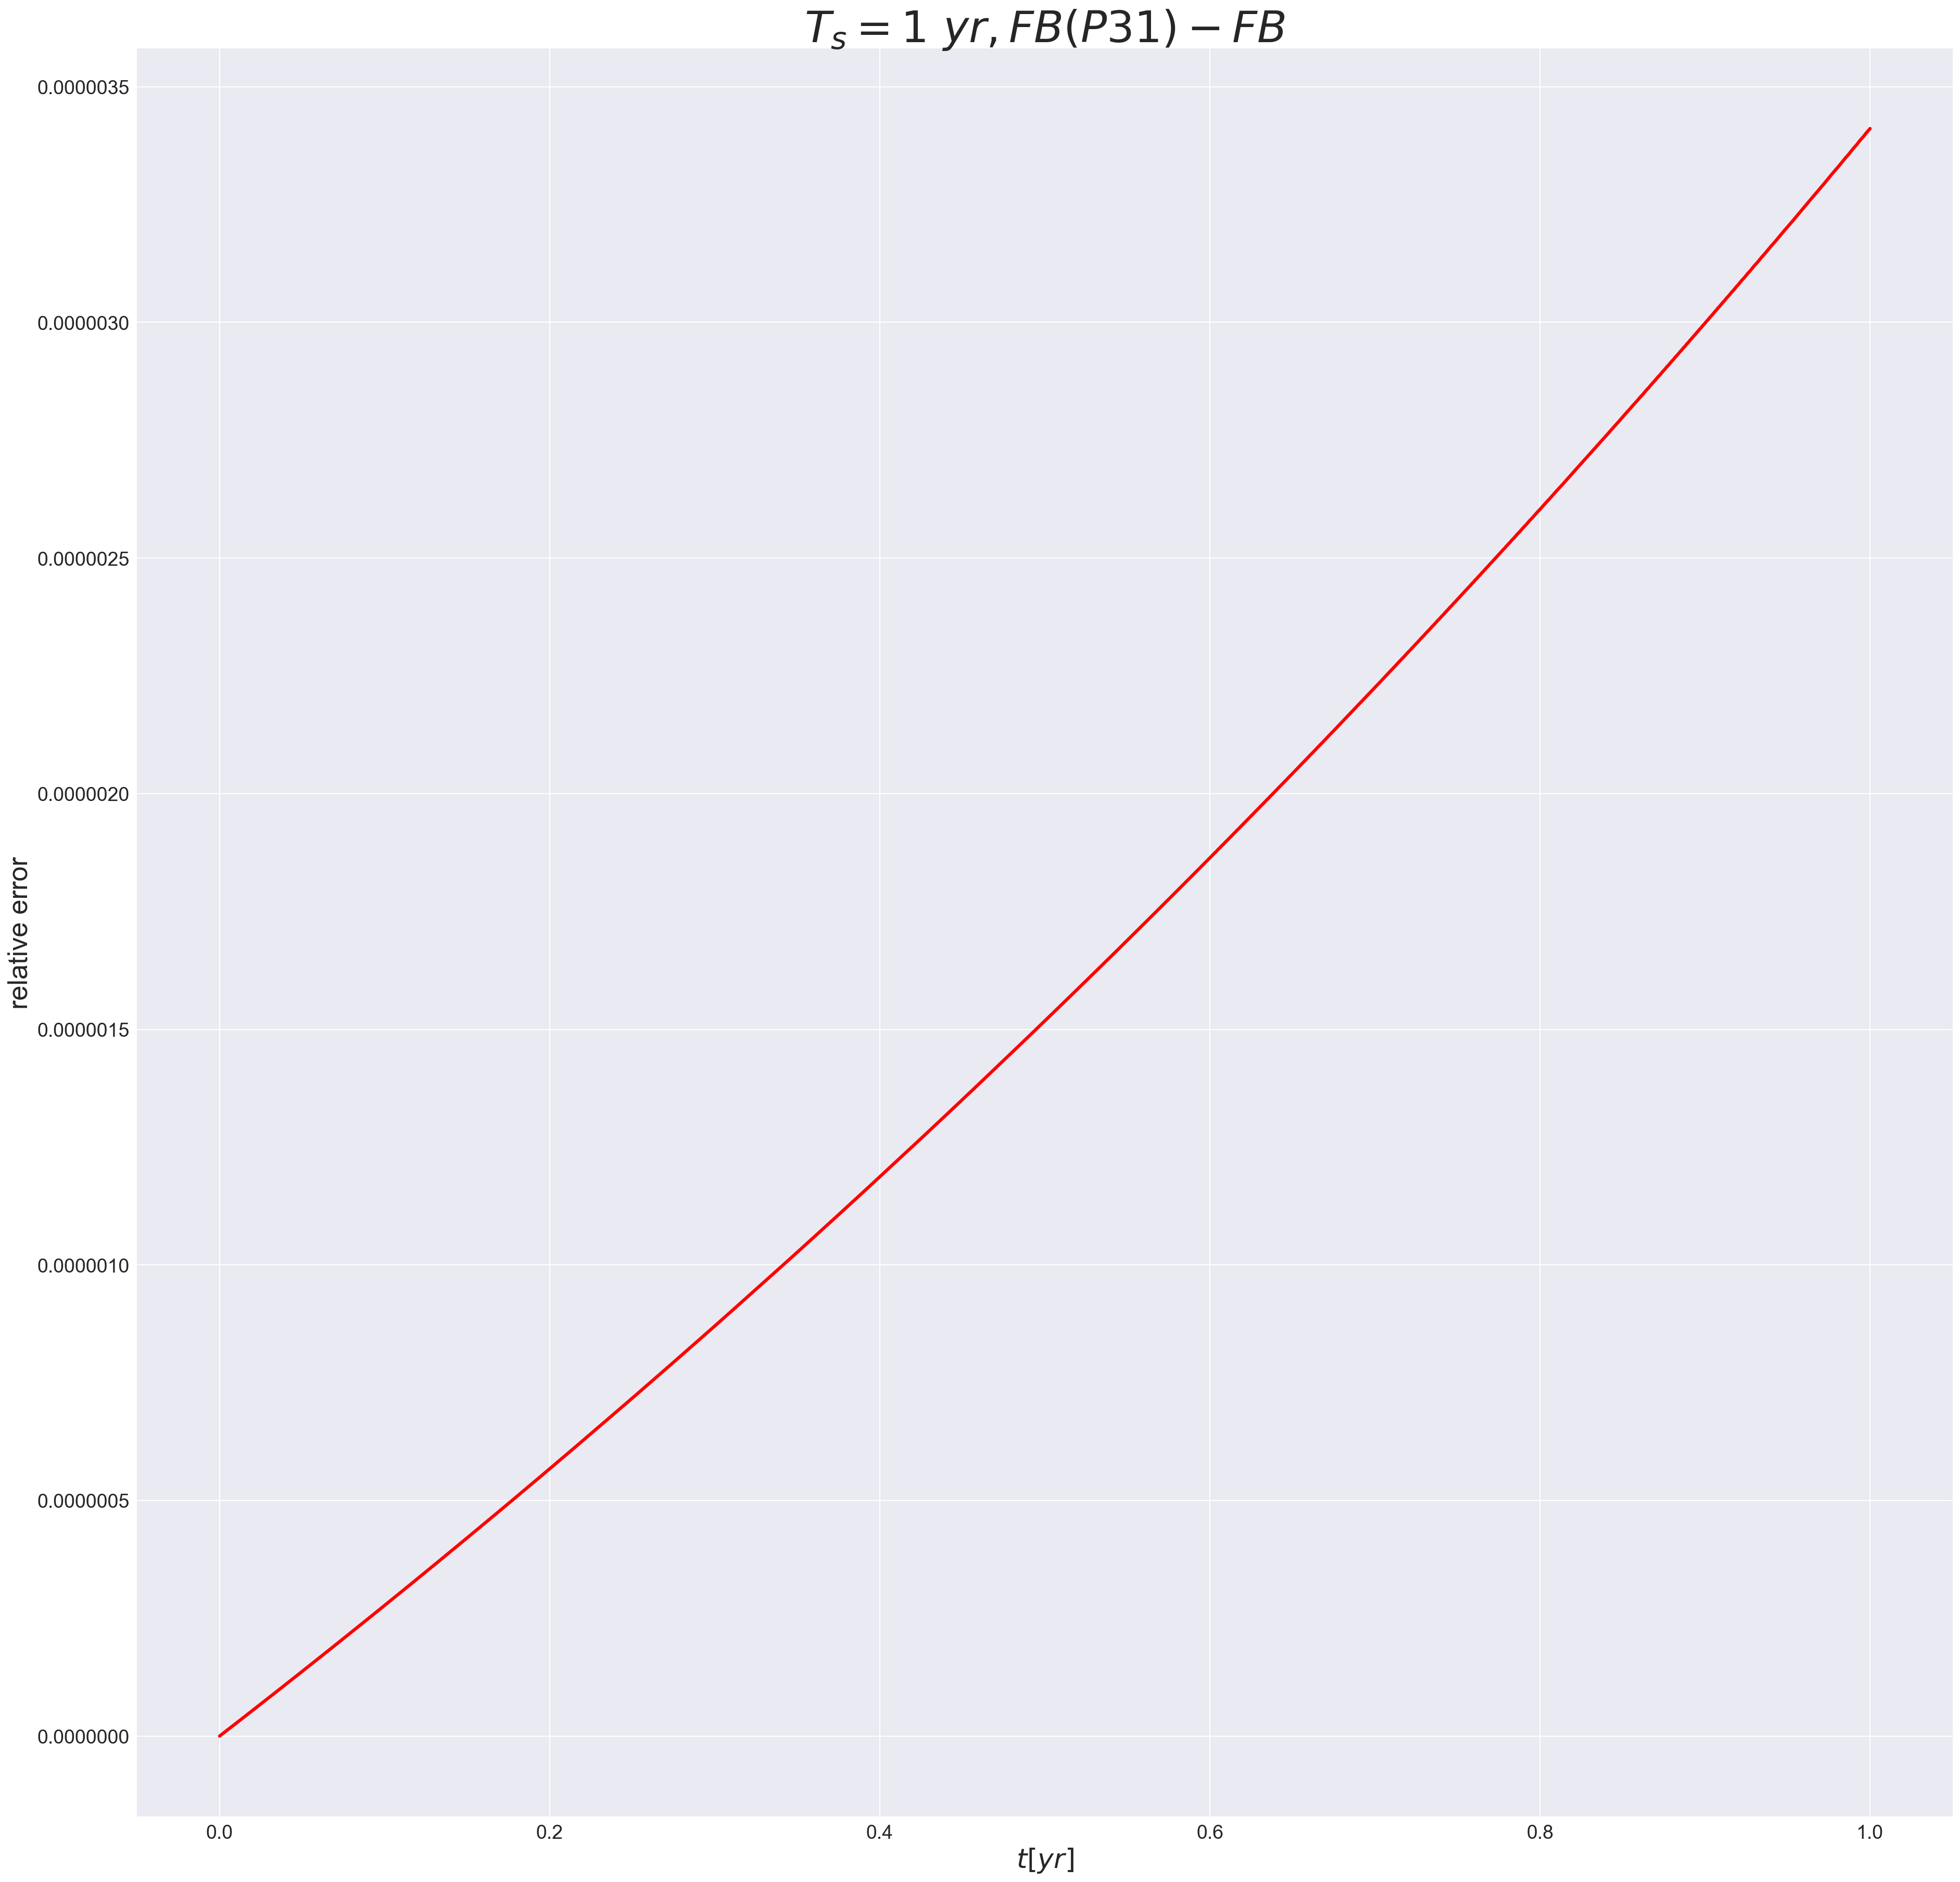

In [55]:
plt.clf()
fig1=plt.figure(figsize=(30,30),dpi=150)
err=abs(rp31(tdomin)-rp1(tdomin))/rp1(tdomin)
plt.title(r'$T_s=1\ yr,FB(P31)-FB$',fontsize=40)
plt.ylabel('relative error',fontsize=25)
plt.xlabel(r'$t[yr]$',fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(tdomin/yr,err,color='red',linewidth=3.0)
#plt.plot(tdomin,errp31,color='blue',linewidth=3.0)
plt.show()

ValueError: A value in x_new is below the interpolation range.

array([ 0.002     ,  0.002     ,  0.002     , ...,  0.00181764,
        0.00181764,  0.00181764])